# REINFORCE in PyTorch

Just like we did before for Q-learning, this time we'll design a PyTorch network to learn `CartPole-v0` via policy gradient (REINFORCE).

Most of the code in this notebook is taken from approximate Q-learning, so you'll find it more or less familiar and even simpler.

Acknowledgements for this great notebook to the [Practical_RL](https://github.com/yandexdataschool/Practical_RL) course team.

In [3]:
!pip install gymnasium --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 11.2 MB/s eta 0:00:00


In [4]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

Selecting previously unselected package libfontenc1:amd64.
(Reading database ... 122349 files and directories currently installed.)
Preparing to unpack .../0-libfontenc1_1%3a1.1.4-0ubuntu1_amd64.deb ...
Unpacking libfontenc1:amd64 (1:1.1.4-0ubuntu1) ...
Selecting previously unselected package libxfont2:amd64.
Preparing to unpack .../1-libxfont2_1%3a2.0.3-1_amd64.deb ...
Unpacking libxfont2:amd64 (1:2.0.3-1) ...
Selecting previously unselected package libxkbfile1:amd64.
Preparing to unpack .../2-libxkbfile1_1%3a1.1.0-1_amd64.deb ...
Unpacking libxkbfile1:amd64 (1:1.1.0-1) ...
Selecting previously unselected package x11-xkb-utils.
Preparing to unpack .../3-x11-xkb-utils_7.7+5_amd64.deb ...
Unpacking x11-xkb-utils (7.7+5) ...
Selecting previously unselected package xfonts-encodings.
Preparing to unpack .../4-xfonts-encodings_1%3a1.0.5-0ubuntu1_all.deb ...
Unpacking xfonts-encodings (1:1.0.5-0ubuntu1) ...
Selecting previously unselected package xfonts-utils.
Preparing to unpack .../5-xfont

In [9]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

A caveat: with some versions of `pyglet`, the following cell may crash with `NameError: name 'base' is not defined`. The corresponding bug report is [here](https://github.com/pyglet/pyglet/issues/134). If you see this error, try restarting the kernel.

In [10]:
env = gym.make("CartPole-v1")
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

In [11]:
env.reset()


(array([ 0.0231731 , -0.0132879 ,  0.03220604, -0.01076773], dtype=float32),
 {})

# Building the network for REINFORCE

For REINFORCE algorithm, we'll need a model that predicts action probabilities given states.

For numerical stability, please __do not include the softmax layer into your network architecture__.
We'll use softmax or log-softmax where appropriate.

In [13]:
import torch
import torch.nn as nn

In [14]:
# Build a simple neural network that predicts policy logits. 
# Keep it simple: CartPole isn't worth deep architectures.
model = nn.Sequential(*[
    nn.Linear(state_dim[0], 16),
    nn.ReLU(),
    nn.Linear(16, 16),
    nn.ReLU(),
    nn.Linear(16, n_actions)
])

In [16]:
s, _ = env.reset()

In [21]:
model(torch.tensor([s]))

<ipython-input-21-ce57aa602f39>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  model(torch.tensor([s]))


tensor([[0.1469, 0.0925]], grad_fn=<AddmmBackward0>)

#### Predict function

Note: output value of this function is not a torch tensor, it's a numpy array.
So, here gradient calculation is not needed.
<br>
Use [no_grad](https://pytorch.org/docs/stable/autograd.html#torch.autograd.no_grad)
to suppress gradient calculation.
<br>
Also, `.detach()` (or legacy `.data` property) can be used instead, but there is a difference:
<br>
With `.detach()` computational graph is built but then disconnected from a particular tensor,
so `.detach()` should be used if that graph is needed for backprop via some other (not detached) tensor;
<br>
In contrast, no graph is built by any operation in `no_grad()` context, thus it's preferable here.

In [27]:
def predict_probs(states):
    """ 
    Predict action probabilities given states.
    :param states: numpy array of shape [batch, state_shape]
    :returns: numpy array of shape [batch, n_actions]
    """
    # convert states, compute logits, use softmax to get probability
    logits = model(torch.from_numpy(states)).detach().cpu()
    probs = torch.softmax(logits, dim=1).numpy()
    return probs

In [28]:
test_states = np.array([env.reset()[0] for _ in range(5)])
test_probas = predict_probs(test_states)
assert isinstance(test_probas, np.ndarray), \
    "you must return np array and not %s" % type(test_probas)
assert tuple(test_probas.shape) == (test_states.shape[0], env.action_space.n), \
    "wrong output shape: %s" % np.shape(test_probas)
assert np.allclose(np.sum(test_probas, axis=1), 1), "probabilities do not sum to 1"

### Play the game

We can now use our newly built agent to play the game.

In [29]:
def generate_session(env, t_max=1000):
    """ 
    Play a full session with REINFORCE agent.
    Returns sequences of states, actions, and rewards.
    """
    # arrays to record session
    states, actions, rewards = [], [], []
    s, _ = env.reset()

    for t in range(t_max):
        # action probabilities array aka pi(a|s)
        action_probs = predict_probs(np.array([s]))[0]

        # Sample action with given probabilities.
        a = np.random.choice(n_actions, p=action_probs)
        new_s, r, done, info, _ = env.step(a)

        # record session history to train later
        states.append(s)
        actions.append(a)
        rewards.append(r)

        s = new_s
        if done:
            break

    return states, actions, rewards

In [30]:
# test it
states, actions, rewards = generate_session(env)

### Computing cumulative rewards

$$
\begin{align*}
G_t &= r_t + \gamma r_{t + 1} + \gamma^2 r_{t + 2} + \ldots \\
&= \sum_{i = t}^T \gamma^{i - t} r_i \\
&= r_t + \gamma * G_{t + 1}
\end{align*}
$$

In [35]:
def get_cumulative_rewards(rewards,  # rewards at each step
                           gamma=0.99  # discount for reward
                           ):
    """
    Take a list of immediate rewards r(s,a) for the whole session 
    and compute cumulative returns (a.k.a. G(s,a) in Sutton '16).
    
    G_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...

    A simple way to compute cumulative rewards is to iterate from the last
    to the first timestep and compute G_t = r_t + gamma*G_{t+1} recurrently

    You must return an array/list of cumulative rewards with as many elements as in the initial rewards.
    """
    cumulative_rewards_reversed = [0 for _ in rewards]
    prev_cumulative_reward = 0
    for idx, reward in enumerate(rewards[::-1]):
      cumulative_rewards_reversed[idx] = reward + gamma * prev_cumulative_reward
      prev_cumulative_reward = cumulative_rewards_reversed[idx]

    return np.asarray(cumulative_rewards_reversed[::-1])

In [36]:
get_cumulative_rewards(rewards)
assert len(get_cumulative_rewards(list(range(100)))) == 100
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, 0, 0, 1, 0], gamma=0.9),
    [1.40049, 1.5561, 1.729, 0.81, 0.9, 1.0, 0.0])
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, -2, 3, -4, 0], gamma=0.5),
    [0.0625, 0.125, 0.25, -1.5, 1.0, -4.0, 0.0])
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, 2, 3, 4, 0], gamma=0),
    [0, 0, 1, 2, 3, 4, 0])
print("looks good!")

looks good!


#### Loss function and updates

We now need to define objective and update over policy gradient.

Our objective function is

$$ J \approx  { 1 \over N } \sum_{s_i,a_i} G(s_i,a_i) $$

REINFORCE defines a way to compute the gradient of the expected reward with respect to policy parameters. The formula is as follows:

$$ \nabla_\theta \hat J(\theta) \approx { 1 \over N } \sum_{s_i, a_i} \nabla_\theta \log \pi_\theta (a_i \mid s_i) \cdot G_t(s_i, a_i) $$

We can abuse PyTorch's capabilities for automatic differentiation by defining our objective function as follows:

$$ \hat J(\theta) \approx { 1 \over N } \sum_{s_i, a_i} \log \pi_\theta (a_i \mid s_i) \cdot G_t(s_i, a_i) $$

When you compute the gradient of that function with respect to network weights $\theta$, it will become exactly the policy gradient.

In [38]:
def to_one_hot(y_tensor, ndims):
    """ helper: take an integer vector and convert it to 1-hot matrix. """
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    y_one_hot = torch.zeros(
        y_tensor.size()[0], ndims).scatter_(1, y_tensor, 1)
    return y_one_hot

In [39]:
# Your code: define optimizers
optimizer = torch.optim.Adam(model.parameters(), 1e-3)


def train_on_session(states, actions, rewards, gamma=0.99, entropy_coef=1e-2):
    """
    Takes a sequence of states, actions and rewards produced by generate_session.
    Updates agent's weights by following the policy gradient above.
    Please use Adam optimizer with default parameters.
    """

    # cast everything into torch tensors
    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.int32)
    cumulative_returns = np.array(get_cumulative_rewards(rewards, gamma))
    cumulative_returns = torch.tensor(cumulative_returns, dtype=torch.float32)

    # predict logits, probas and log-probas using an agent.
    logits = model(states)
    probs = nn.functional.softmax(logits, -1)
    log_probs = nn.functional.log_softmax(logits, -1)

    assert all(isinstance(v, torch.Tensor) for v in [logits, probs, log_probs]), \
        "please use compute using torch tensors and don't use predict_probs function"

    # select log-probabilities for chosen actions, log pi(a_i|s_i)
    log_probs_for_actions = torch.sum(
        log_probs * to_one_hot(actions, env.action_space.n), dim=1)
   
    # Compute loss here. Don't forgen entropy regularization with `entropy_coef` 
    entropy = -torch.sum(log_probs * probs, dim=1).mean()
    # <YOUR CODE>
    loss = -torch.mean(log_probs_for_actions * cumulative_returns) # <YOUR CODE>

    optimized_function = loss - entropy_coef * entropy
    # Gradient descent step
    optimizer.zero_grad()
    optimized_function.backward()
    optimizer.step()

    # technical: return session rewards to print them later
    return np.sum(rewards)

### The actual training

In [41]:
for i in range(100):
    rewards = [train_on_session(*generate_session(env)) for _ in range(100)]  # generate new sessions
    
    print("mean reward:%.3f" % (np.mean(rewards)))
    
    if np.mean(rewards) > 475:
        print("You Win!")  # but you can train even further
        break

mean reward:231.220
mean reward:186.140
mean reward:372.760
mean reward:646.720
You Win!


In [45]:
from gymnasium.utils.save_video import save_video

In [43]:
env = gym.make('CartPole-v1', render_mode="rgb_array")

In [49]:
env.reset()

(array([-0.03452038, -0.03385395, -0.02906066, -0.01981678], dtype=float32),
 {})

In [52]:
gym.__version__

'0.28.1'

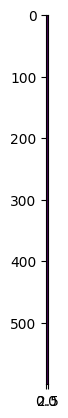

In [53]:
plt.imshow(env.render()[0])

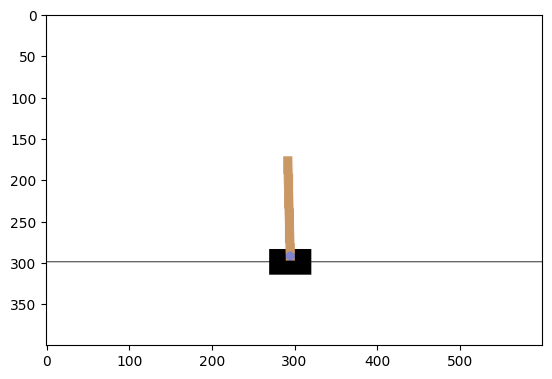

In [56]:
plt.imshow(env.render())

In [60]:
from gymnasium.utils.save_video import save_video
env = gym.make('CartPole-v1', render_mode="rgb_array")

step_starting_index = 0
episode_index = 0
frames = []
s, _ = env.reset()
for step_index in range(1000):

    action_probs = predict_probs(np.array([s]))[0]
    a = np.random.choice(n_actions, p=action_probs)

    frames.append(env.render())

    s, r, done, info, _ = env.step(a)

    if done:
        save_video(
             frames, 
             ".", 
             fps=env.metadata["render_fps"], 
             step_starting_index=step_starting_index, 
             episode_index=episode_index
        )
        step_starting_index = 0
        episode_index += 1
        s = env.reset()[0]

env.close()

Moviepy - Building video /content/rl-video-episode-0.mp4.
Moviepy - Writing video /content/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/rl-video-episode-0.mp4
Moviepy - Building video /content/rl-video-episode-1.mp4.
Moviepy - Writing video /content/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /content/rl-video-episode-1.mp4
